# 0. IMPORTS

In [92]:
import pandas as pd
import inflection
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display         import Image
from tabulate                import tabulate
from sklearn                 import preprocessing, metrics
from scipy.stats             import chi2_contingency
from sklearn.preprocessing   import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import mean_absolute_error, confusion_matrix
from sklearn.svm             import SVC

## 0.1. Data import

In [2]:
df_train = pd.read_csv('data/cardio_train.csv', delimiter = ';')

## 0.2. Helper Functions

In [3]:
def cramer_v(var1,var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Crosstab building
    chi2 = chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1) 
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## 0.3. Graph visualization

In [4]:

from IPython.core.display import HTML

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [18, 8]
   plt.rcParams['font.size'] = 20
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. DESCRIBE DATA 

In [5]:
df1 = df_train.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 
            'alco', 'active', 'cardio']

df1 = df1.rename(columns = {'ap_hi': 'systolic_bp', 'ap_lo': 'diastolic_bp', 'gluc': 'glucose', 
                     'smoke': 'smoking', 'alco': 'alcohol_intake','active': 'physical_activity', 
                     'cardio': 'cardio_disease'})

In [7]:
df1.head()

,id,age,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,glucose,smoking,alcohol_intake,physical_activity,cardio_disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.2. Data Dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of columns: 13


## 1.3. Data Types

In [9]:
df1.dtypes

id                     int64
age                    int64
gender                 int64
height                 int64
weight               float64
systolic_bp            int64
diastolic_bp           int64
cholesterol            int64
glucose                int64
smoking                int64
alcohol_intake         int64
physical_activity      int64
cardio_disease         int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

id                   0
age                  0
gender               0
height               0
weight               0
systolic_bp          0
diastolic_bp         0
cholesterol          0
glucose              0
smoking              0
alcohol_intake       0
physical_activity    0
cardio_disease       0
dtype: int64

## 1.5. Fillout NA
(Not necessary)

## 1.6. Change Data Type

In [11]:
df1[['gender', 'cholesterol', 'glucose', 'smoking', 'alcohol_intake', 'physical_activity', 
          'cardio_disease']] = df1[['gender', 'cholesterol', 'glucose', 'smoking', 'alcohol_intake', 
          'physical_activity', 'cardio_disease']].astype('object')

In [12]:
df1.dtypes

id                     int64
age                    int64
gender                object
height                 int64
weight               float64
systolic_bp            int64
diastolic_bp           int64
cholesterol           object
glucose               object
smoking               object
alcohol_intake        object
physical_activity     object
cardio_disease        object
dtype: object

## 1.7. Descriptive Statistics


In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1. Numerical Variables

In [64]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.mean())
ct2 = pd.DataFrame(num_attributes.median())

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std())
d2 = pd.DataFrame(num_attributes.min())
d3 = pd.DataFrame(num_attributes.max())
d4 = pd.DataFrame(num_attributes.max() - num_attributes.min())
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# concat
df_num = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6], axis = 1)
df_num.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_num

,mean,median,std,min,max,range,skew,kurtosis
id,49972.419900,50001.5,28851.302323,0.0,99999.0,99999.0,-0.001278,-1.198374
age,19468.865814,19703.0,2467.251667,10798.0,23713.0,12915.0,-0.307055,-0.823447
height,164.359229,165.0,8.210126,55.0,250.0,195.0,-0.642187,7.943653
weight,74.205690,72.0,14.395757,10.0,200.0,190.0,1.012070,2.586825
systolic_bp,128.817286,120.0,154.011419,-150.0,16020.0,16170.0,85.296214,7580.074738
diastolic_bp,96.630414,80.0,188.472530,-70.0,11000.0,11070.0,32.114083,1425.914585


### 1.7.2. Categorical Variables

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender               2
cholesterol          3
glucose              3
smoking              2
alcohol_intake       2
physical_activity    2
cardio_disease       2
dtype: int64

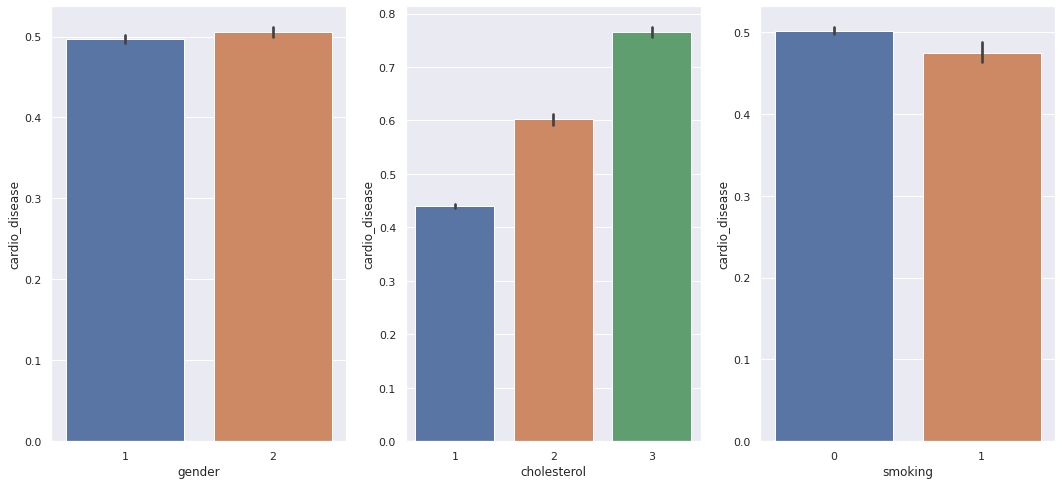

In [15]:
plt.subplot(1,3,1)
sns.barplot(x = "gender", y = "cardio_disease", data = df1);

plt.subplot(1,3,2)
sns.barplot(x = "cholesterol", y = "cardio_disease", data = df1);

plt.subplot(1,3,3)
sns.barplot(x = "smoking", y = "cardio_disease", data = df1);

# 2. FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

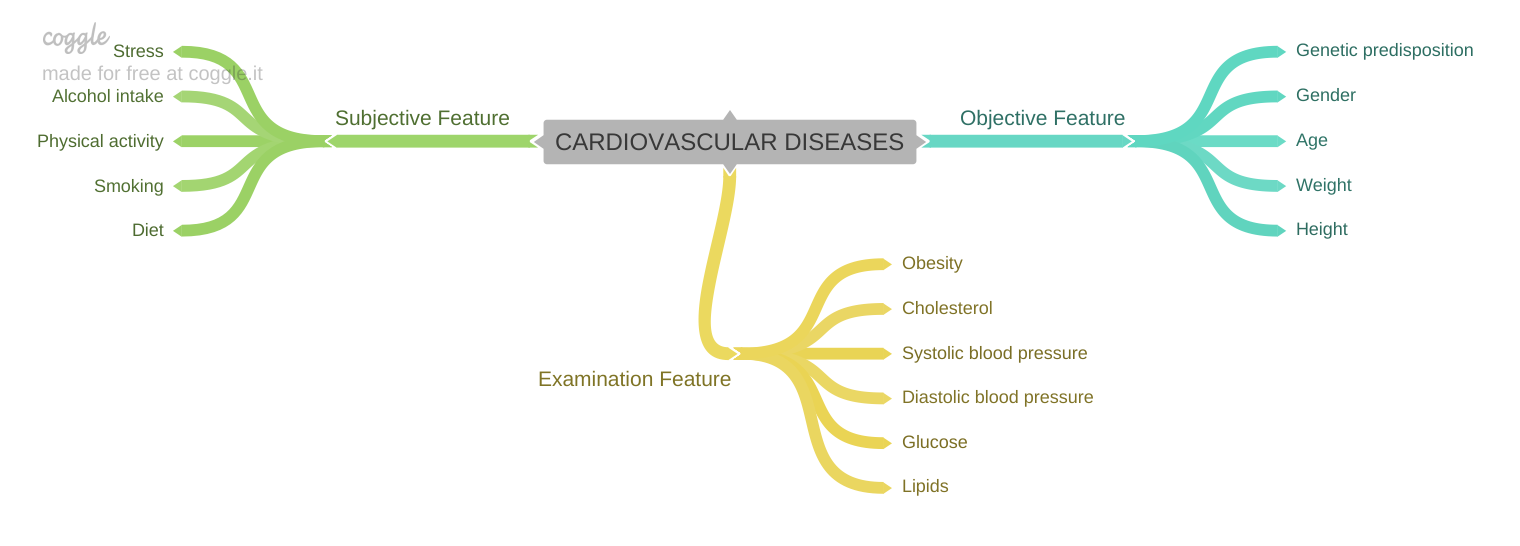

In [17]:
Image(filename='img/CARDIOVASCULAR_DISEASES.png')

## 2.2. Hypothesis Development

### 2.2.1. Objective Features

**1.** People with **some genetic predisposition** are **most likely to present** cardiovascular diseases.

**2.** **Men** are most likely to **present** cardiovascular diseases.

**3.** People with **overweight** are **most likely to present** cardiovascular diseases.

**4.** **Older** people are **most likely to present** cardiovascular diseases.

### 2.2.2. Subjective Features

**1.** People dealing with more daily **stress** are **most likely to present** cardiovascular diseases.

**2.** People who **drink alcohol** are **most likely to present** cardiovascular diseases.

**3.** People who practice regular **physical activities** are **less likely to present** cardiovascular diseases.

**4.** People who **smoke** are **most likely to present** cardiovascular diseases.

**5.** People with a **regular and healthy diet** are **less likely to present** cardiovascular diseases.

### 2.2.3. Examination Features

**1.** People with **obesity** are **most likely to present** cardiovascular diseases.

**2.** People who present **high cholesterol levels** are **most likely to present** cardiovascular diseases.

**3.** **High glucose levels** people are **most likely to present** cardiovascular diseases.

**4.** People with **hypertension** are **most likely to present** cardiovascular diseases.

## 2.3. Feature Engineering

### 2.3.1. Modified Columns

In [15]:
df2['age'] = (df2['age']/365).astype('int64')

df2['gender'] = df2['gender'].apply(lambda x: 'feminine' if x == 1 else 'masculine')

df2['height'] = df2['height']/100

df2['cholesterol'] = df2['cholesterol'].apply(lambda x: 'normal' if x == 1 else 'above_normal' if x == 2 else 'well_above_normal')

df2['glucose'] = df2['glucose'].apply(lambda x: 'normal' if x == 1 else 'above_normal' if x == 2 else 'well_above_normal')

### 2.3.2. Created Columns

In [16]:
df2['bp_level'] = df2['systolic_bp'].apply(lambda x: 'normal' if x < 130 else 'pre_hypertension' if 130 <= x < 140 
                                           else 'hypertension')

df2['BMI'] = (df2['weight'] / np.square(df2['height'])).round(1)

df2['weight_status'] = df2['BMI'].apply(lambda x: 'underweight' if x < 18.5 
                                        else 'normal' if x < 25 
                                        else 'overweight' if x < 30 
                                        else 'obese')

# 3. VARIABLE FILTERING

In [17]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [20]:
df3 = df3[(df3['systolic_bp'] >= 80) & (df3['systolic_bp'] <= 240) 
          & (df3['diastolic_bp'] >= 50) & (df3['diastolic_bp'] <= 140)]

df3 = df3[(df3['height'] > 1.20) & (df3['height'] <= 2.10) 
          & (df3['weight'] >= 40) & (df3['BMI'] <= 60)]

## 3.2. Columns Selection

In [19]:
df3 = df3.drop('id', axis = 1)

# 4. EXPLORATORY DATA ANALYSIS

In [21]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable
(To think)

### 4.1.2. Numerical Variables

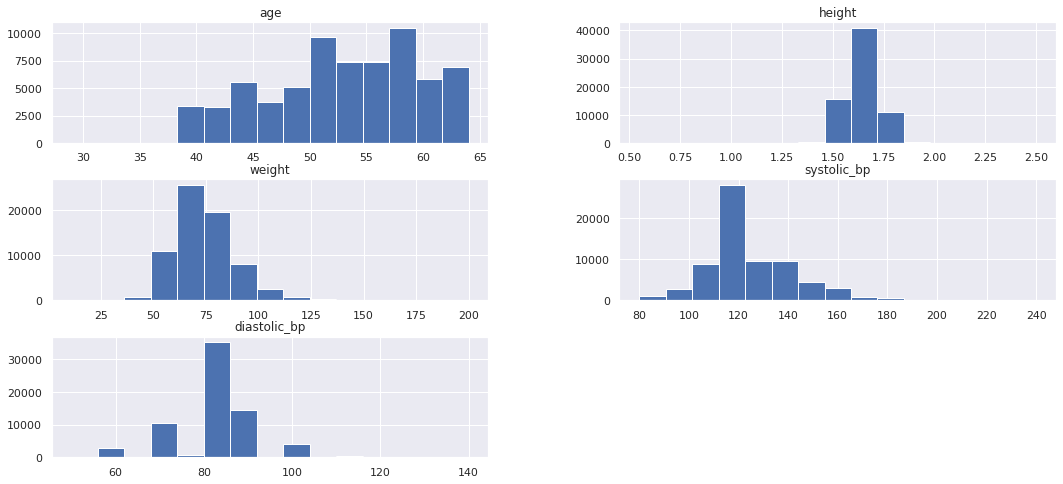

In [80]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])

num_attributes.hist(bins = 15);

### 4.1.3. Categorical Variables

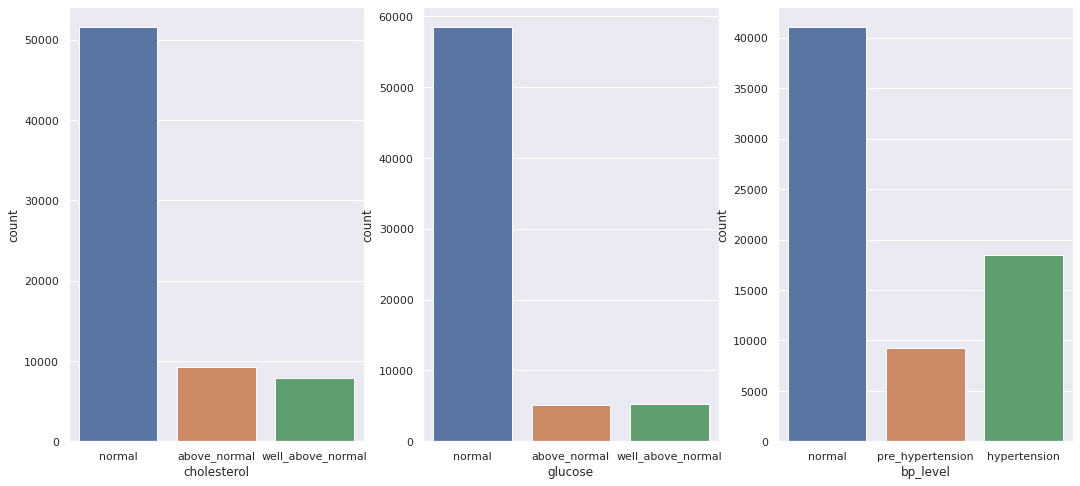

In [98]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

plt.subplot(1, 3, 1)
sns.countplot(x = df4['cholesterol'], order = ('normal', 'above_normal', 'well_above_normal'));

plt.subplot(1, 3, 2)
sns.countplot(x = df4['glucose'], order = ('normal', 'above_normal', 'well_above_normal'));

plt.subplot(1, 3, 3)
sns.countplot(x = df4['bp_level'], order = ('normal', 'pre_hypertension', 'hypertension'));

## 4.2. Bivariate Analysis

### 4.2.1. Individual Analysis of the Hypothesis

**H1.** **Men** are most likely to **present** cardiovascular diseases.

**TRUE**, although difference in percentage is not expressive.

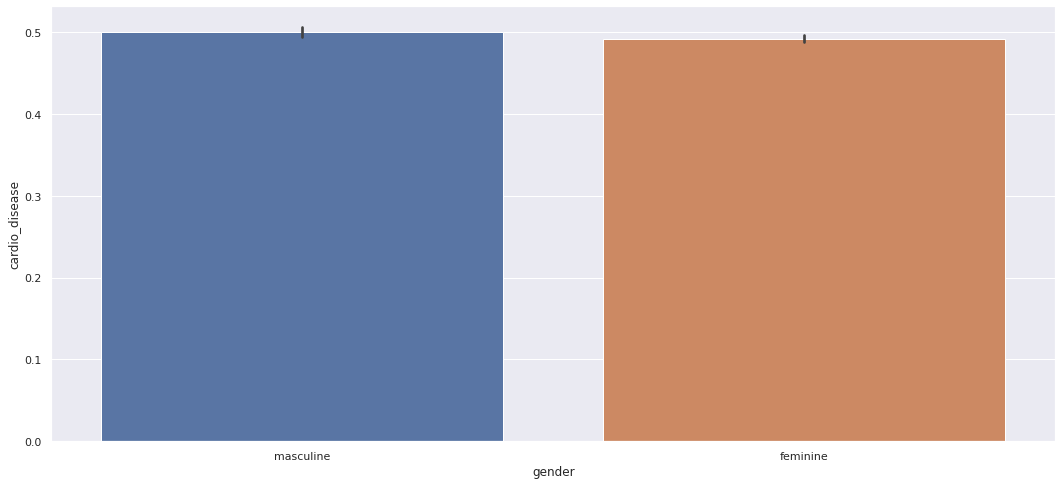

In [103]:
sns.barplot(x = "gender", y = "cardio_disease", data = df4);

**H2.** People with **obesity** are **most likely to present** cardiovascular diseases.

**TRUE**, as well as people with underweight tend to have less cadiac diseases.

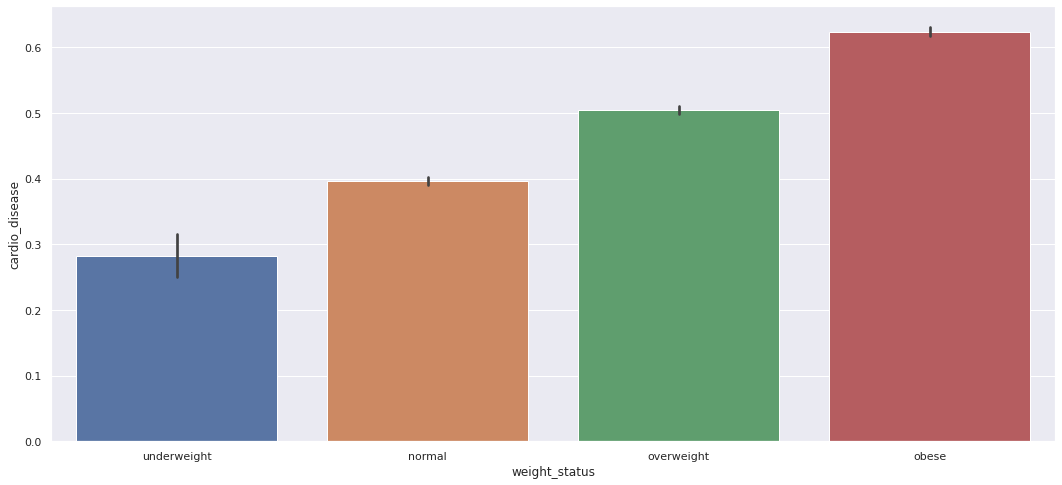

In [333]:
sns.barplot(x = 'weight_status', y = 'cardio_disease', data = df4, order = ('underweight', 'normal', 'overweight', 'obese'));

**H3.** **Older** people are **most likely to present** cardiovascular diseases.

**TRUE**

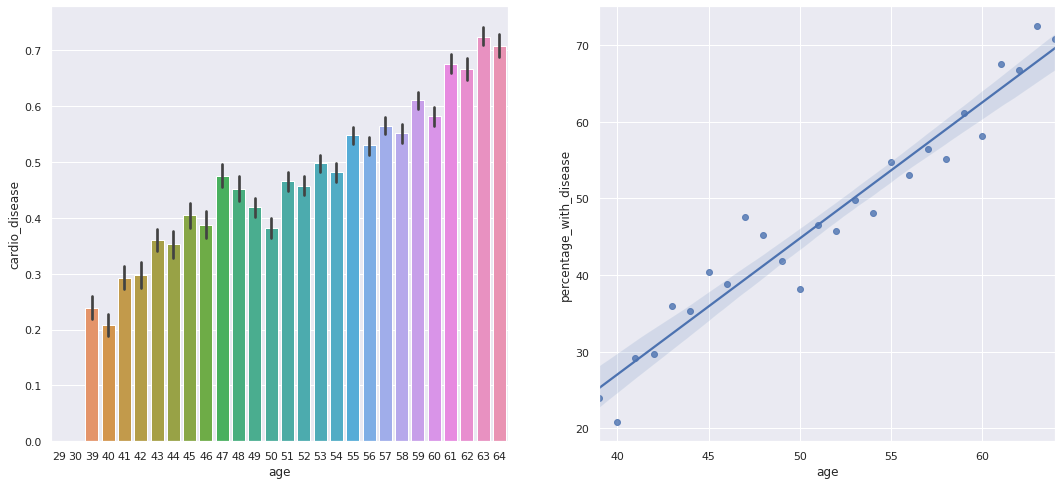

In [306]:
aux = df4.groupby(['age', 'cardio_disease']).agg({'cardio_disease': 'count'})

aux1 = aux.groupby(level = 0).apply(lambda x: (100 * x / float(x.sum())).round(2)).reset_index(0)
aux1 = aux1[aux1.index == 1].rename(columns = {'cardio_disease': 'percentage_with_disease'})

plt.subplot(1, 2, 1)
sns.barplot(x = 'age', y = 'cardio_disease', data = df4);

plt.subplot(1, 2, 2)
sns.regplot(x = 'age', y = 'percentage_with_disease', data = aux1);

**H4.** People who **drink alcohol** are **most likely to present** cardiovascular diseases.

**FALSE**, although difference in percentage is not very expressive.

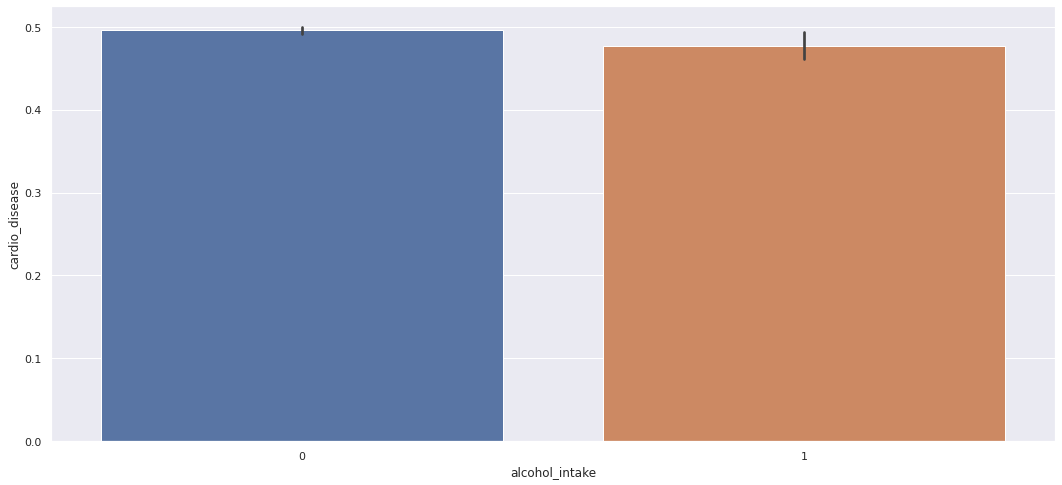

In [313]:
sns.barplot(x = 'alcohol_intake', y = 'cardio_disease', data = df4);

**H5.** People who practice regular **physical activities** are **less likely to present** cardiovascular diseases.

**TRUE**

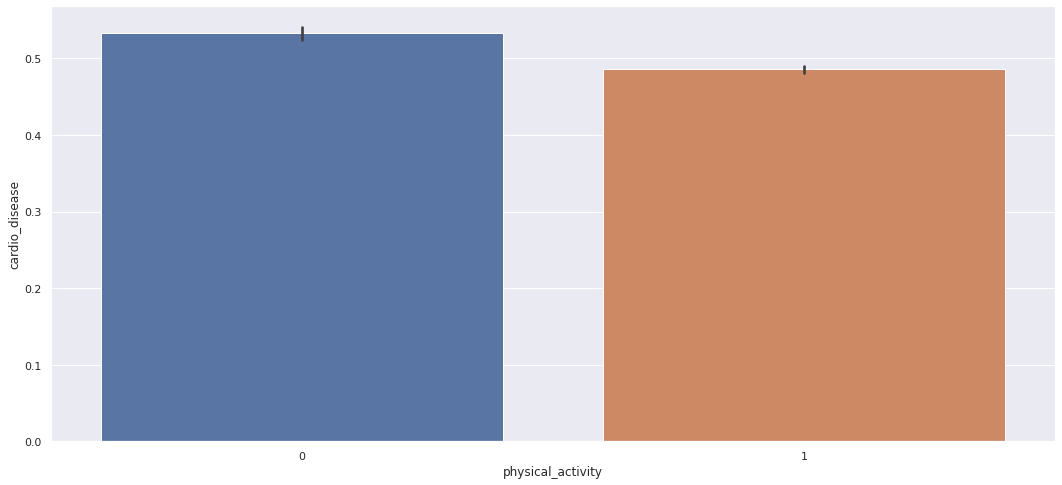

In [314]:
sns.barplot(x = 'physical_activity', y = 'cardio_disease', data = df4);

**H6.** People who **smoke** are **most likely to present** cardiovascular diseases.

**FALSE**

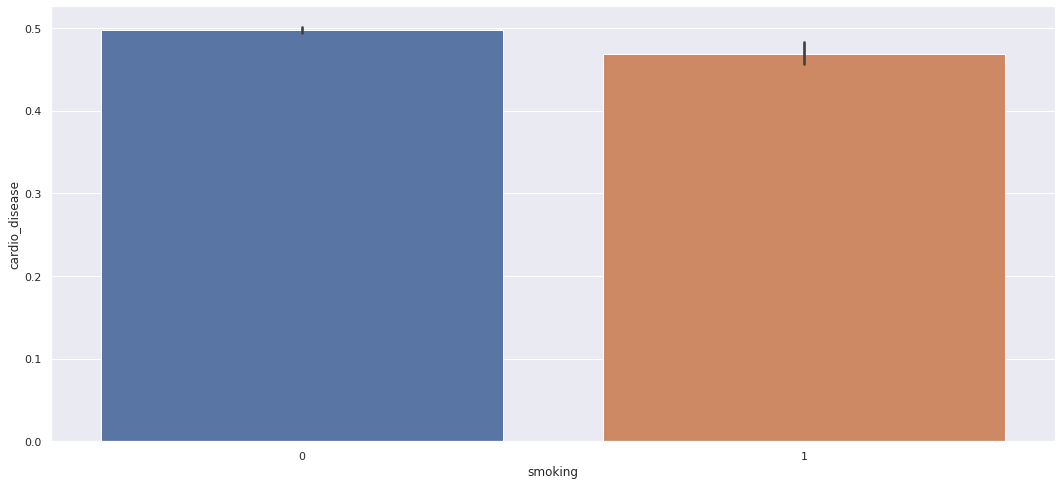

In [315]:
sns.barplot(x = 'smoking', y = 'cardio_disease', data = df4);

**H7.** People who present **high cholesterol levels** are **most likely to present** cardiovascular diseases.

**TRUE**, and those variables seems to have a strong correlation

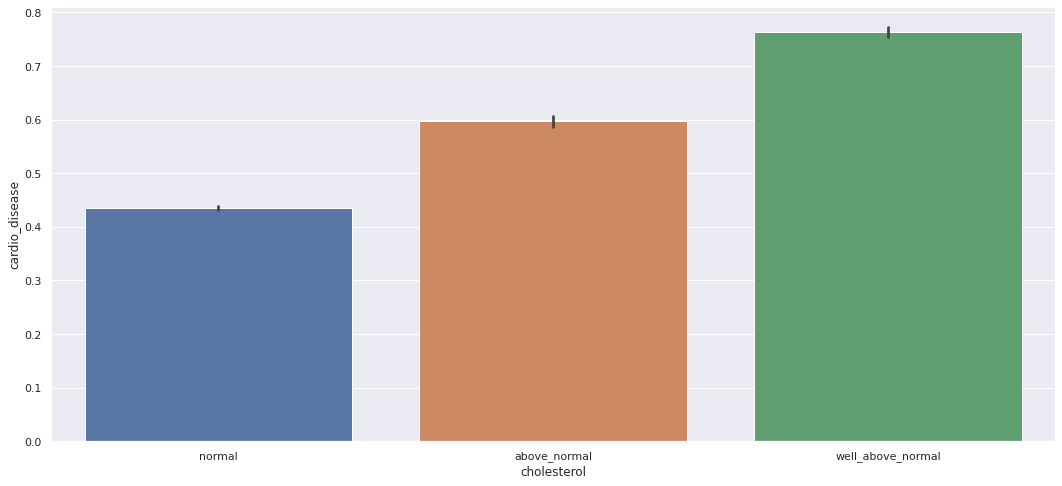

In [317]:
sns.barplot(x = 'cholesterol', y = 'cardio_disease', data = df4, order = ('normal', 'above_normal', 'well_above_normal'));

**H8.** **High glucose levels** people are **most likely to present** cardiovascular diseases.

**TRUE**

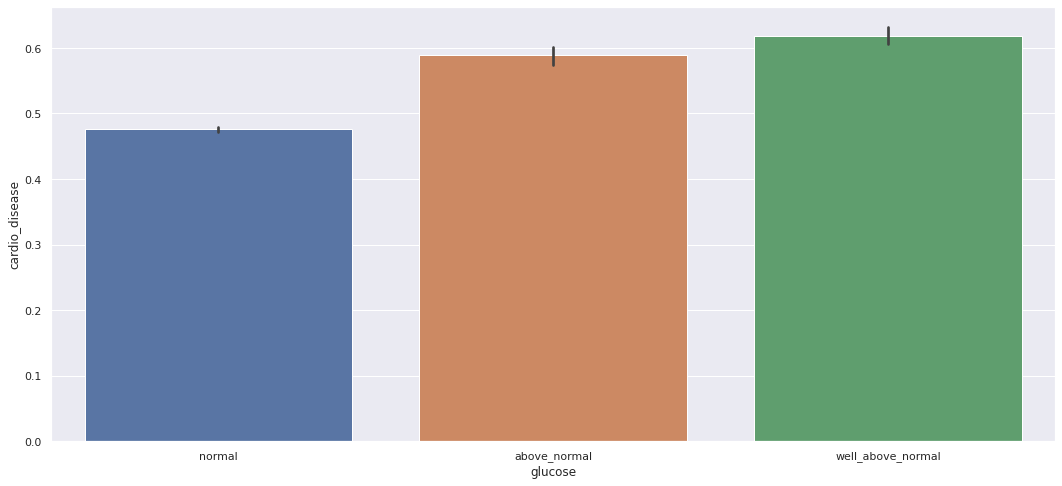

In [318]:
sns.barplot(x = 'glucose', y = 'cardio_disease', data = df4);

**H9.** People with **hypertension** are **most likely to present** cardiovascular diseases.

**TRUE**, and those variables seems to have a strong correlation

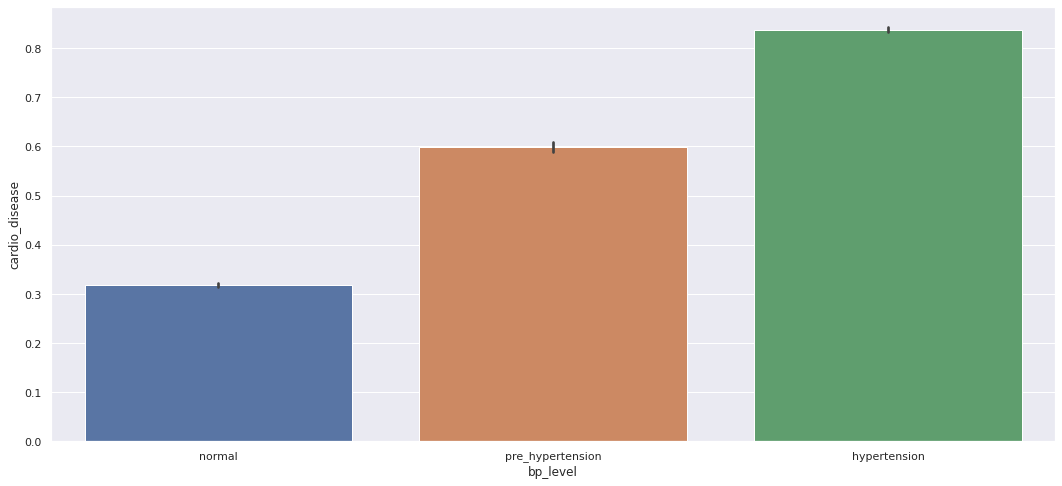

In [320]:
sns.barplot(x = 'bp_level', y = 'cardio_disease', data = df4, order = ('normal', 'pre_hypertension', 'hypertension'));

### 4.2.2. General Hypothesis Overview

In [338]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1. Men are most likely to present cardiovascular diseases', 'True', 'Low'],
       ['H2. People with obesity are most likely to present cardiovascular diseases', 'True', 'High'],
       ['H3. Older people are most likely to present cardiovascular diseases', 'True', 'High'],
       ['H4. People who drink alcohol are most likely to present cardiovascular diseases', 'False', 'Low'],
       ['H5. People who practice regular physical activities are less likely to present cardiovascular diseases', 'True', 'Low'],
       ['H6. People who smoke are most likely to present cardiovascular diseases', 'False', 'Low'],
       ['H7. People who present high cholesterol levels are most likely to present cardiovascular diseases', 'True', 'High'],
       ['H8. High glucose levels people are most likely to present cardiovascular diseases', 'True', 'Moderate'],
       ['H9. People with hypertension are most likely to present cardiovascular diseases', 'True', 'High']
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis                                                                                              Conclusion    Relevance
------------------------------------------------------------------------------------------------------  ------------  -----------
H1. Men are most likely to present cardiovascular diseases                                              True          Low
H2. People with obesity are most likely to present cardiovascular diseases                              True          High
H3. Older people are most likely to present cardiovascular diseases                                     True          High
H4. People who drink alcohol are most likely to present cardiovascular diseases                         False         Low
H5. People who practice regular physical activities are less likely to present cardiovascular diseases  True          Low
H6. People who smoke are most likely to present cardiovascular diseases                                 False         Low
H7. Peop

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

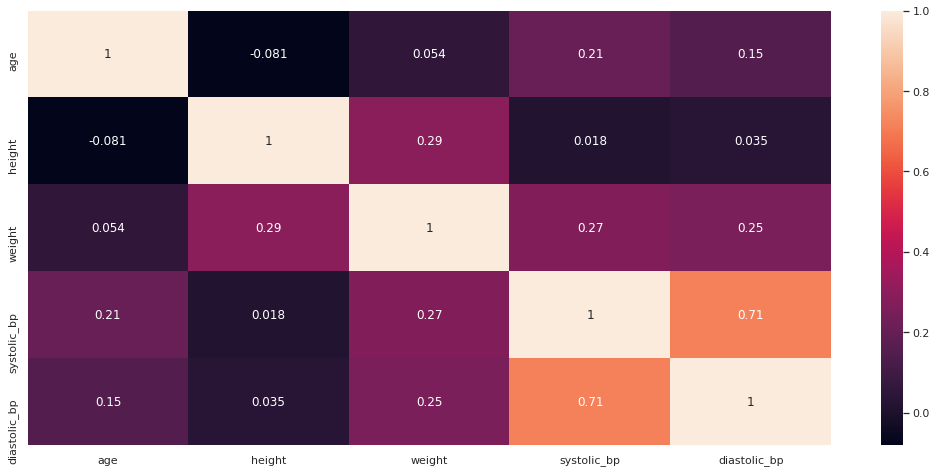

In [340]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes

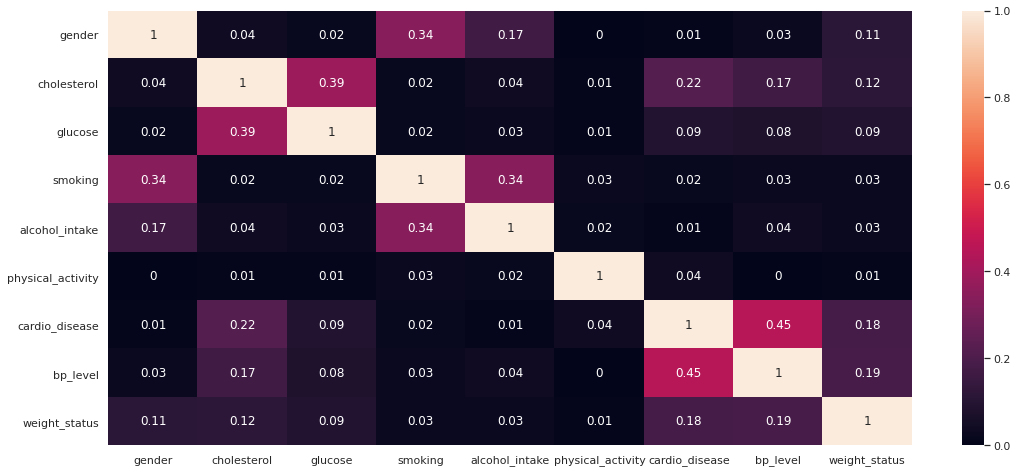

In [376]:
a = df4.select_dtypes(include = 'object')

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in a.columns :
    data_encoded[i] = label.fit_transform(a[i])

rows = []

for var1 in data_encoded:
    col = []
    
    for var2 in data_encoded :
        cramer = cramer_v(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramer, 2)) # Keeping of the rounded value of the Cramer's V  
    
    rows.append(col)
    
cramer_results = np.array(rows)
d = pd.DataFrame(cramer_results, columns = data_encoded.columns, index = data_encoded.columns)

sns.heatmap(d, annot = True);

# 5. DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1. Normalization

(None)

## 5.2. Rescaling

In [54]:
mms = MinMaxScaler()
rs = RobustScaler()

# age - range 35.00 (no)
df5['age'] = mms.fit_transform(df5[['age']].values)

# height - 0.82 (no)

# weight - 160.00 (RobustScaler)
df5['weight'] = mms.fit_transform(df5[['weight']].values)

# systolic - 160.00 (MinMaxScaler)
df5['systolic_bp'] = mms.fit_transform(df5[['systolic_bp']].values)

# diastolic - 90.00 (MinMaxScaler)
df5['diastolic_bp'] = mms.fit_transform(df5[['diastolic_bp']].values)

# BMI - 46 (MinMaxScaler)
df5['BMI'] = mms.fit_transform(df5[['BMI']].values)

## 5.3. Transformation

### 5.3.1. Response Variable

(None)

### 5.3.2. Encoding

In [55]:
# gender - OrdinalEncoder
assort_dict1 = {'feminine': 1,
               'masculine': 2}
df5['gender'] = df5['gender'].map(assort_dict1)

# cholesterol - OrdinalEncoder
assort_dict2 = {'normal': 1,
               'above_normal': 2,
               'well_above_normal': 3}
df5['cholesterol'] = df5['cholesterol'].map(assort_dict2)

# glucose - OrdinalEncoder
df5['glucose'] = df5['glucose'].map(assort_dict2)

# bp_level - OrdinalEncoder
assort_dict3 = {'normal': 1,
               'pre_hypertension': 2,
               'hypertension': 3}
df5['bp_level'] = df5['bp_level'].map(assort_dict3)

# weight_status - OrdinalEncoder
assort_dict4 = {'underweight': 1,
               'normal': 2,
               'overweight': 3,
               'obese': 4}
df5['weight_status'] = df5['weight_status'].map(assort_dict4)

### 5.3.3. Nature Transformation

(None)

# 6. FEATURE SELECTION

In [134]:
df6 = df5.copy()

## 6.1. Split DataFrame into Training and Test

In [135]:
train, test = train_test_split(df6, test_size = 0.2, random_state = 42, shuffle = True)

X_train = train
y_train = X_train['cardio_disease']

X_test = test
y_test = X_test['cardio_disease']

## 6.2. Boruta as Feature Selector

In [58]:
# conversion of df/series to numpy and remotion of variables that do not compose training ('cardio_disease')
x_train_n = X_train.drop(['cardio_disease'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
I

### 6.2.1. Best Features

In [63]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['cardio_disease'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# unconsidered columns
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Saving Best Features (Boruta + Selected from EDA)

In [136]:
cols_selected_boruta = ['systolic_bp', # the only selected by Boruta
                        'age',
                        'cholesterol',
                        'weight_status']

#columns to add
feat_to_add = ['cardio_disease']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7. MACHINE LEARNING MODELS

In [137]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [138]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

## 7.1. Logistic Regression

In [31]:
# model
lr = LogisticRegression()
lr.fit(x_train, y_train)

# prediction
y_hat = lr.predict(x_test)

# # performance
lr_result = lr.score(x_test, y_test)
lr_result

0.7234011521913513

### 7.1.1.  Logistic Regression - Cross Validation

In [32]:
cv_lr = cross_val_score(estimator = lr, X = x_train, y = y_train, cv = 10)

In [47]:
print("Logistic Regression accuracy: ", cv_lr.mean())
print("Logistic Regression standart Deviation: ", cv_lr.std())

lr_result_cv = cv_lr.mean()

Logistic Regression accuracy:  0.7252769405586618
Logistic Regression standart Deviation:  0.005578761642503207


## 7.2. Random Forest Classification

In [34]:
# model
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# prediction
y_hat = rf.predict(x_test)

# # performance
rf_result = rf.score(x_test, y_test)
rf_result

0.7222343761394298

### 7.1.2. Random Forest - Cross Validation

In [35]:
cv_rf = cross_val_score(estimator = rf, X = x_train, y = y_train, cv = 10)

In [46]:
print("Logistic Regression accuracy: ", cv_rf.mean())
print("Logistic Regression standart Deviation: ", cv_rf.std())

rf_result_cv = cv_rf.mean()

Logistic Regression accuracy:  0.7205182790808696
Logistic Regression standart Deviation:  0.00470888301589732


## 7.3. Support Vector Classification

In [37]:
# model
svc = SVC(random_state = 6).fit(x_train, y_train)

# prediction
y_hat = svc.predict(x_test)

# # performance
svc_result = svc.score(x_test, y_test)
svc_result

0.7252971632757238

### 7.1.3. Support Vector Classification - Cross Validation

In [38]:
cv_svc = cross_val_score(estimator = svc, X = x_train, y = y_train, cv = 10)

In [44]:
print("Support Vector Classification accuracy: ", cv_svc.mean())
print("Support Vector Classification standart Deviation: ", cv_svc.std())

svc_result_cv = cv_svc.mean()

Support Vector Classification accuracy:  0.7205182923788569
Support Vector Classification standart Deviation:  0.007586737666395953


## 7.4. Compare Model's Performance

### 7.4.1. Single Performance

In [48]:
modelling_result = pd.DataFrame([['Logistic Regression', 'Random Forest Classification', 'Support Vector Classification'],
                    [lr_result, rf_result, svc_result]]).T.rename(columns = {0: 'ML Model', 1: 'Accuracy'})
modelling_result.sort_values('Accuracy', ascending = False)

,ML Model,Accuracy
2,Support Vector Classification,0.725297
0,Logistic Regression,0.723401
1,Random Forest Classification,0.722234


### 7.4.2. Real Performance (Cross-Validation)

In [49]:
modelling_result_cv = pd.DataFrame([['Logistic Regression', 'Random Forest Classification', 'Support Vector Classification'],
                    [lr_result_cv, rf_result_cv, svc_result_cv]]).T.rename(columns = {0: 'ML Model', 1: 'Accuracy'})
modelling_result_cv.sort_values('Accuracy', ascending = False)

,ML Model,Accuracy
0,Logistic Regression,0.725277
2,Support Vector Classification,0.720518
1,Random Forest Classification,0.720518


# 8. HYPERPARAMETER FINE TUNING

## 8.1. Grid Search - Logistic Regression

In [142]:
log_reg = LogisticRegression(solver = 'liblinear', max_iter = 200)
grid = {'penalty': ['l1', 'l2'], 'C': [0.001,.009,0.01,.09,1,5,10,25]}
log_reg_cv = GridSearchCV(log_reg, param_grid = grid, cv = 3)
log_reg_cv.fit(x_train, y_train.to_list())

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=200, solver='liblinear'),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']})

In [83]:
# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(log_reg_cv.best_params_)) 
print("Best score: {}".format(log_reg_cv.best_score_))

Tuned hyperparameter n_estimators: {'C': 1, 'penalty': 'l1'}
Best score: 0.7252771190339399


## 8.2. Final Model

In [143]:
# model
lr_tuned = LogisticRegression(solver = 'liblinear', max_iter = 200, penalty = 'l1', C = 1)
lr_tuned.fit(x_train, y_train.to_list())

# prediction
y_hat = lr_tuned.predict(x_test)

# # performance
lr_result_tuned = lr_tuned.score(x_test, y_test.to_list())
lr_result_tuned

0.7234011521913513

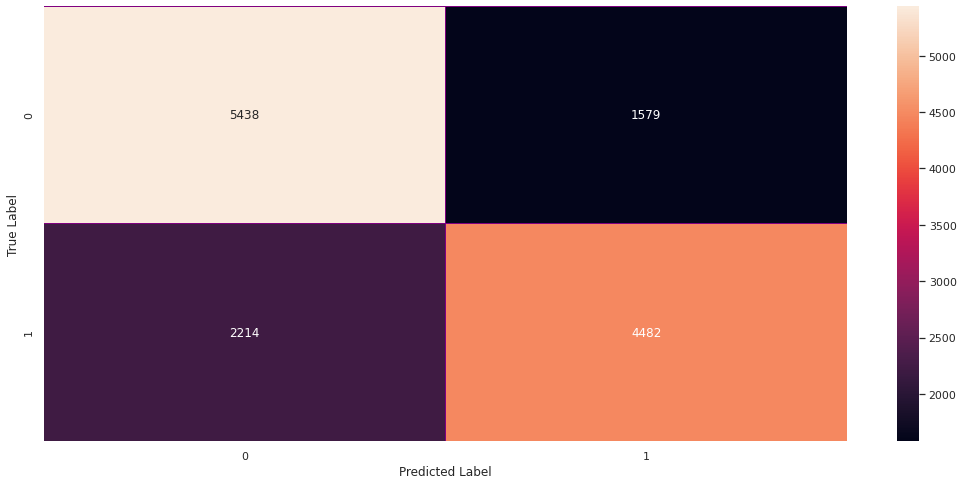

In [145]:
y_true = y_test
y_pred = lr_tuned.predict(x_test)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm,fmt = ".0f", annot = True,linewidths = 0.2, linecolor = "purple")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()